In [2]:
import os
import numpy as np
from helpers import *
from models import *   
from nan_imputation import impute_nan
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator
from load_data import load_lifespan, load_earlylifespan
from nan_imputation import *

In [3]:
repo_root = find_repo_root()
data_path = os.path.join(repo_root, 'Data')
fdict = load_lifespan(data_path)

c:\Users\Utente\Documents\GitHub\ML-Project-2\Data\Lifespan/control\speeds_and_coordinates_20241016_11_updated.csv
File loaded as CSV.
c:\Users\Utente\Documents\GitHub\ML-Project-2\Data\Lifespan/control\speeds_and_coordinates_20241016_12_updated.csv
File loaded as CSV.
c:\Users\Utente\Documents\GitHub\ML-Project-2\Data\Lifespan/control\speeds_and_coordinates_20241016_13_updated.csv
File loaded as CSV.
c:\Users\Utente\Documents\GitHub\ML-Project-2\Data\Lifespan/control\speeds_and_coordinates_20241016_14_updated.csv
File loaded as CSV.
c:\Users\Utente\Documents\GitHub\ML-Project-2\Data\Lifespan/control\speeds_and_coordinates_20241016_15_updated.csv
File loaded as CSV.
c:\Users\Utente\Documents\GitHub\ML-Project-2\Data\Lifespan/control\speeds_and_coordinates_20241016_16_updated.csv
File loaded as CSV.
c:\Users\Utente\Documents\GitHub\ML-Project-2\Data\Lifespan/control\speeds_and_coordinates_20241016_31_updated.csv
File loaded as CSV.
c:\Users\Utente\Documents\GitHub\ML-Project-2\Data\Life

In [4]:
fdict.pop('worm_14_Lifespan/companyDrug')

array([], shape=(1, 0), dtype=object)

In [5]:
# Rows to check for missing values (2:4 in zero-based indexing)
rows_to_check = slice(2, 4)  # Rows 2, 3, 4

# Process all arrays in the dictionary
cut_lifespan_dict = {name: cut_array(array, rows_to_check) for name, array in fdict.items()}

In [6]:
for name, item in cut_lifespan_dict.items():
    print(name.split(sep='/')[1])

control
control
control
control
control
control
control
control
control
control
control
control
companyDrug
companyDrug
companyDrug
companyDrug
companyDrug
companyDrug
companyDrug
companyDrug
companyDrug
companyDrug
companyDrug
companyDrug
Terbinafin
Terbinafin
Terbinafin
Terbinafin
Terbinafin
Terbinafin
Terbinafin
Terbinafin
Terbinafin
Terbinafin
Terbinafin
Terbinafin
ATR+
ATR+
ATR+
ATR+
ATR+
ATR+
ATR+
ATR+
ATR+
ATR+
ATR+
ATR+
ATR+
ATR+
ATR+
ATR+
ATR+
ATR+
ATR+
ATR+
ATR-
ATR-
ATR-
ATR-
ATR-
ATR-
ATR-
ATR-
ATR-
ATR-
ATR-
ATR-
ATR-
ATR-
ATR-
ATR-
ATR-
ATR-
ATR-
ATR-
ATR-
ATR-


In [ ]:
lenghts = np.zeros(shape=(len(cut_lifespan_dict), 2))
idx = 0 
for name, item in cut_lifespan_dict.items():
    currname = name.split(sep='/')[1]
    if (currname == 'control') or (currname == 'controlTebrafin'):
        lenghts[idx,0] = 0
        lenghts[idx, 1] = item.shape[1]
    elif currname == 'companyDrug':
        lenghts[idx,0] = 1
        lenghts[idx, 1] = item.shape[1]
    elif currname == 'Tebrafin':
        lenghts[idx,0] = 2
        lenghts[idx, 1] = item.shape[1]    
    elif currname == 'ATR+':
        lenghts[idx,0] = 3
        lenghts[idx, 1] = item.shape[1]
    elif currname == 'ATR-':
        lenghts[idx,0] = 4
        lenghts[idx, 1] = item.shape[1]
    idx += 1
idx = 0

Text(0.5, 0, 'time $t$')

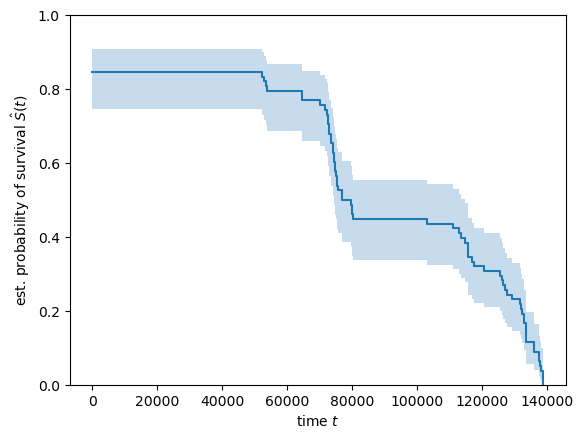

In [8]:
larr = np.array(lenghts[:,1])
stat = np.full(larr.shape, True)
time, survival_prob, conf_int = kaplan_meier_estimator(
    stat, larr, conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

In [9]:
from isdead import estimate_dying_time
death_times = []
for name, item in cut_lifespan_dict.items():
    print(f'worm name: {name}')
    arrdf = pd.DataFrame(item.T)
    if arrdf.shape[1] == 5:
        arrdf.columns = ['Frame','Speed','X','Y','Changed Pixels']
    else:
        arrdf.columns = ['Frame','Speed','X','Y','Changed Pixels','ATR']
    estimate_dying_time(arrdf, movement_threshold=1.0)
    dying_frame,absolute_frame,dying_time_hours,segment_number = estimate_dying_time(arrdf, movement_threshold=1.0)
    if absolute_frame is not None:
        death_times.append(absolute_frame)
    else:
        death_times.append(arrdf.shape[0])

worm name: worm_0_Lifespan/control
worm name: worm_1_Lifespan/control
worm name: worm_2_Lifespan/control
worm name: worm_3_Lifespan/control
worm name: worm_4_Lifespan/control
worm name: worm_5_Lifespan/control
worm name: worm_6_Lifespan/control
worm name: worm_7_Lifespan/control
worm name: worm_8_Lifespan/control
worm name: worm_9_Lifespan/control
worm name: worm_10_Lifespan/control
worm name: worm_11_Lifespan/control
worm name: worm_0_Lifespan/companyDrug
worm name: worm_2_Lifespan/companyDrug
worm name: worm_3_Lifespan/companyDrug
worm name: worm_4_Lifespan/companyDrug
worm name: worm_5_Lifespan/companyDrug
worm name: worm_6_Lifespan/companyDrug
worm name: worm_7_Lifespan/companyDrug
worm name: worm_8_Lifespan/companyDrug
worm name: worm_10_Lifespan/companyDrug
worm name: worm_11_Lifespan/companyDrug
worm name: worm_12_Lifespan/companyDrug
worm name: worm_13_Lifespan/companyDrug
worm name: worm_0_Lifespan/Terbinafin
worm name: worm_1_Lifespan/Terbinafin
worm name: worm_2_Lifespan/Ter

Text(0.5, 0, 'time $t$')

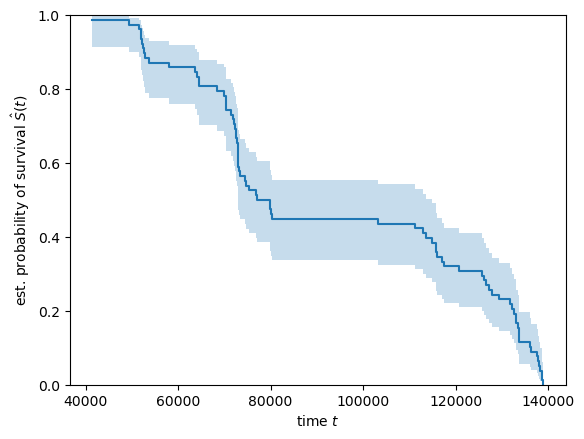

In [10]:
larr = np.array(death_times)
stat = np.full(larr.shape, True)
time, survival_prob, conf_int = kaplan_meier_estimator(
    stat, larr, conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

In [11]:
np.min(death_times)

np.int64(41440)

In [16]:
X = np.zeros(shape=(len(death_times),51890, 5))

In [20]:
X[1].shape

(51890, 5)

In [17]:
X = np.zeros(shape=(len(death_times),51890, 5))
c = 0
for name, arr in cut_lifespan_dict.items():
    X[c] = arr.T[:51890,:5]

In [18]:
lenghts[:,0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.])

In [20]:
y_reg = np.array(death_times)
y_class = np.array(lenghts[:,0].astype(int))

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, y_train_class, y_test_class = train_test_split(X, y_reg, y_class, test_size=0.2, random_state=1)

In [22]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input

In [33]:
from keras.layers import AveragePooling1D
from keras.models import Model

In [30]:
n_classes = len(np.unique(y_train_class))

In [12]:
#from tensorflow.keras.utils import plot_model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score

In [37]:
from keras.utils import to_categorical

y_train_class_onehot = to_categorical(y_train_class, num_classes=n_classes)
y_test_class_onehot = to_categorical(y_test_class, num_classes=n_classes)

In [38]:
input_layer = Input(shape=(X_train.shape[1],X_train.shape[2]))
downsampled = AveragePooling1D(pool_size=10)(input_layer)
lstm_layer_1 = LSTM(128, return_sequences=True)(downsampled)
lstm_layer_2 = LSTM(64)(lstm_layer_1)
dense_layer = Dense(32, activation='relu')(lstm_layer_2)
# regression output
output_layer_r = Dense(1, activation='linear')(dense_layer)
# classification output
output_layer_c = Dense(n_classes, activation='softmax')(dense_layer)
# define model
model = Model(inputs=input_layer, outputs=[output_layer_r, output_layer_c])
# compile the keras model
model.compile(loss=['mse','categorical_crossentropy'], optimizer='adam')
# plot graph of model
plot_model(model, to_file='model.png', show_shapes=True)
# fit the keras model on the dataset
model.fit(X_train, [y_train,y_train_class_onehot], epochs=15, verbose=2)
# make predictions on test set
yhat1, yhat2 = model.predict(X_test)
# calculate error for regression model
error = mean_absolute_error(y_test, yhat1)
print('MAE: %.3f' % error)
# evaluate accuracy for classification model
yhat2 = np.argmax(yhat2, axis=-1).astype('int')
acc = accuracy_score(y_test_class_onehot, yhat2)
print('Accuracy: %.3f' % acc)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/15
2/2 - 61s - loss: 10013440000.0000 - dense_7_loss: 10013440000.0000 - dense_8_loss: 1.3839 - 61s/epoch - 31s/step
Epoch 2/15
2/2 - 43s - loss: 10013437952.0000 - dense_7_loss: 10013437952.0000 - dense_8_loss: 1.3830 - 43s/epoch - 22s/step
Epoch 3/15
2/2 - 34s - loss: 10013430784.0000 - dense_7_loss: 10013430784.0000 - dense_8_loss: 1.3818 - 34s/epoch - 17s/step
Epoch 4/15
2/2 - 35s - loss: 10013418496.0000 - dense_7_loss: 10013418496.0000 - dense_8_loss: 1.3802 - 35s/epoch - 17s/step
Epoch 5/15
2/2 - 42s - loss: 10013388800.0000 - dense_7_loss: 10013388800.0000 - dense_8_loss: 1.3886 - 42s/epoch - 21s/step
Epoch 6/15
2/2 - 37s - loss: 10013295616.0000 - dense_7_loss: 10013295616.0000 - dense_8_loss: 1.4288 - 37s/epoch - 18s/step
Epoch 7/15
2/2 - 49s - loss: 10012817408.0000 - dense_7_loss: 10012817408.0000 - dense_8_loss: 2.1348

ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

array([133733, 115628, 137693,  72265, 127893, 126192,  72892,  80393,
       138227, 127140, 133444, 132503, 133557, 137872], dtype=int64)

In [12]:
samples = []
for name, item in cut_lifespan_dict.items():
    #print(name)
    #print(item.T[0,1:5])
    arr = item.T[:30000,1:5]
    samples.append(arr)

In [13]:
samples[0].shape

(30000, 4)

In [14]:
from preprocessing_features import preprocess_dataset

In [15]:
# Process the dataset
features = list(preprocess_dataset(samples))

# Convert to DataFrame for easier analysis
import pandas as pd
features_df = pd.DataFrame(features[0:54])

print(features_df.head())

     x_mean      x_std  x_min        x_max      x_range  x_skewness  \
0  2.662863  16.315322    0.0  1361.971102  1361.971102   45.995594   
1  2.089488  16.384629    0.0   936.604212   936.604212   35.454582   
2  3.690146  16.134205    0.0   944.236862   944.236862   32.053172   
3  2.995448  11.641452    0.0   517.485924   517.485924   29.984204   
4  3.205699  12.111608    0.0   617.381782   617.381782   30.422474   

    x_kurtosis      y_mean       y_std       y_min  ...  speed_mean  \
0  2836.800487  423.443077   99.206102   85.323529  ...  154.400907   
1  1489.354602  412.854028  111.015625  122.416667  ...  256.780286   
2  1294.722577  383.950032  115.391025   64.000000  ...  187.036313   
3  1110.007838  460.149417   90.820882  233.506596  ...  157.203221   
4  1140.433853  427.131658   76.308857  211.000000  ...  252.864492   

    speed_std  speed_min   speed_max  speed_range  speed_skewness  \
0  124.283338   0.000000  749.000000   749.000000        2.341068   
1  150.6

In [17]:
len(features)

78

In [18]:
X = pd.DataFrame(features[0:78])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y_reg, test_size=0.3, random_state=42)

In [22]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
stdsc.fit(X_train)
X_train_std = stdsc.transform(X_train)
X_test_std = stdsc.transform(X_test)

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

model = LinearRegression()
model.fit(X_train, y_train)
y_pred_lr = model.predict(X_test)
print('MAE:', mean_absolute_error(y_test, y_pred_lr))

MAE: 15482.43966445256


In [24]:
y_train_pred = model.predict(X_train)

Text(0.5, 0, 'time $t$')

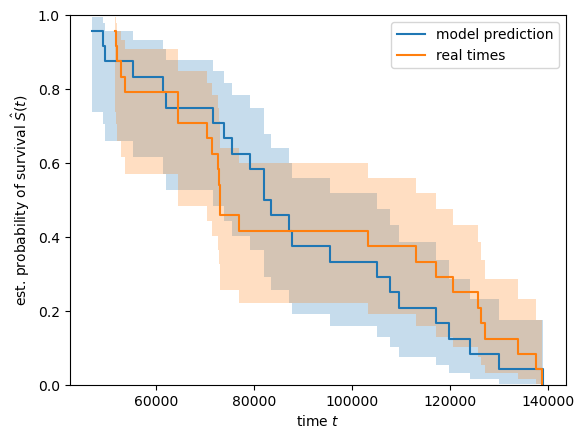

In [25]:
larr = np.array(y_pred_lr)
stat = np.full(larr.shape, True)
time, survival_prob, conf_int = kaplan_meier_estimator(
    stat, larr, conf_type="log-log"
)

larrtr = np.array(y_test)
stattr = np.full(larrtr.shape, True)
time2, survival_prob2, conf_int2 = kaplan_meier_estimator(
    stattr, larrtr, conf_type="log-log"
)

plt.step(time, survival_prob, where="post", label='model prediction')
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.step(time2, survival_prob2, where="post", label='real times')
plt.fill_between(time2, conf_int2[0], conf_int2[1], alpha=0.25, step="post")
plt.legend()
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

In [34]:
from sklearn.linear_model import Ridge, Lasso

model = Ridge(alpha=1.0)  # Use Lasso(alpha=1.0) for feature selection
model.fit(X_train, y_train)
y_pred_rr = model.predict(X_test)

Text(0.5, 0, 'time $t$')

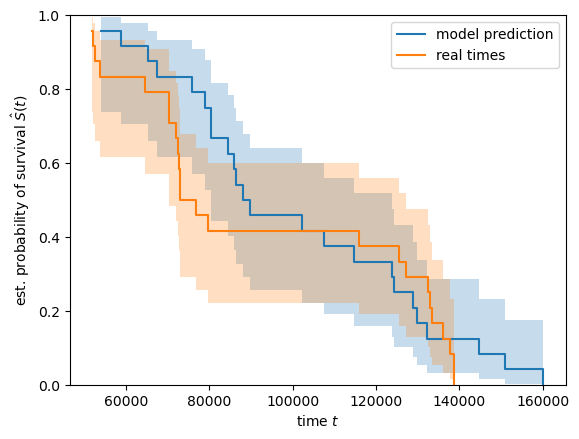

In [35]:
larr = np.array(y_pred_rr)
stat = np.full(larr.shape, True)
time, survival_prob, conf_int = kaplan_meier_estimator(
    stat, larr, conf_type="log-log"
)

larrtr = np.array(y_test)
stattr = np.full(larrtr.shape, True)
time2, survival_prob2, conf_int2 = kaplan_meier_estimator(
    stattr, larrtr, conf_type="log-log"
)

plt.step(time, survival_prob, where="post", label='model prediction')
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.step(time2, survival_prob2, where="post", label='real times')
plt.fill_between(time2, conf_int2[0], conf_int2[1], alpha=0.25, step="post")
plt.legend()
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

In [26]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(max_depth=5)
model.fit(X_train_std, y_train)
y_pred_dtr = model.predict(X_test_std)

In [27]:
len(y_pred_dtr)

24

Text(0.5, 0, 'time $t$')

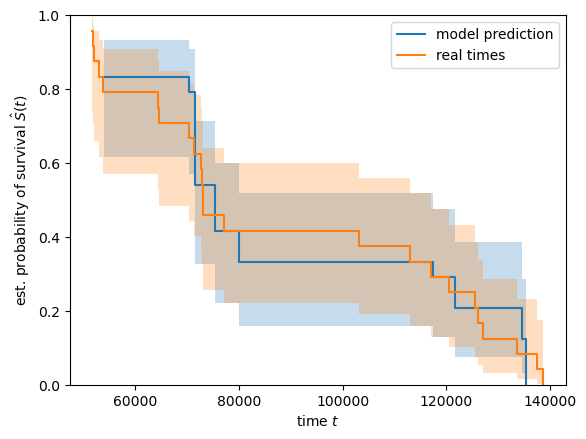

In [28]:
larr = np.array(y_pred_dtr)
stat = np.full(larr.shape, True)
time, survival_prob, conf_int = kaplan_meier_estimator(
    stat, larr, conf_type="log-log"
)

larrtr = np.array(y_test)
stattr = np.full(larrtr.shape, True)
time2, survival_prob2, conf_int2 = kaplan_meier_estimator(
    stattr, larrtr, conf_type="log-log"
)

plt.step(time, survival_prob, where="post", label='model prediction')
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.step(time2, survival_prob2, where="post", label='real times')
plt.fill_between(time2, conf_int2[0], conf_int2[1], alpha=0.25, step="post")
plt.legend()
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

In [38]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred_rfr = model.predict(X_test)

Text(0.5, 0, 'time $t$')

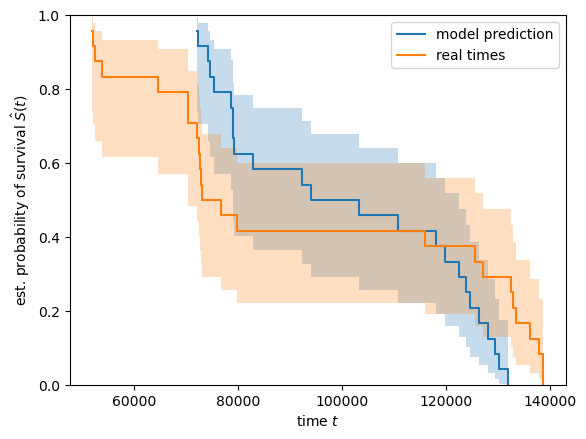

In [39]:
larr = np.array(y_pred_rfr)
stat = np.full(larr.shape, True)
time, survival_prob, conf_int = kaplan_meier_estimator(
    stat, larr, conf_type="log-log"
)

larrtr = np.array(y_test)
stattr = np.full(larrtr.shape, True)
time2, survival_prob2, conf_int2 = kaplan_meier_estimator(
    stattr, larrtr, conf_type="log-log"
)

plt.step(time, survival_prob, where="post", label='model prediction')
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.step(time2, survival_prob2, where="post", label='real times')
plt.fill_between(time2, conf_int2[0], conf_int2[1], alpha=0.25, step="post")
plt.legend()
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

In [40]:
from sklearn.svm import SVR

model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
model.fit(X_train, y_train)
y_pred_svm = model.predict(X_test)

Text(0.5, 0, 'time $t$')

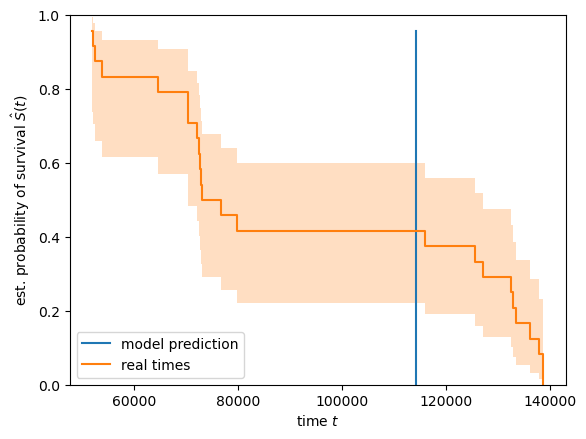

In [41]:
larr = np.array(y_pred_svm)
stat = np.full(larr.shape, True)
time, survival_prob, conf_int = kaplan_meier_estimator(
    stat, larr, conf_type="log-log"
)

larrtr = np.array(y_test)
stattr = np.full(larrtr.shape, True)
time2, survival_prob2, conf_int2 = kaplan_meier_estimator(
    stattr, larrtr, conf_type="log-log"
)

plt.step(time, survival_prob, where="post", label='model prediction')
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.step(time2, survival_prob2, where="post", label='real times')
plt.fill_between(time2, conf_int2[0], conf_int2[1], alpha=0.25, step="post")
plt.legend()
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

In [42]:
features_df.columns

Index(['x_mean', 'x_std', 'x_min', 'x_max', 'x_range', 'x_skewness',
       'x_kurtosis', 'y_mean', 'y_std', 'y_min', 'y_max', 'y_range',
       'y_skewness', 'y_kurtosis', 'direction_change_variance', 'speed_mean',
       'speed_std', 'speed_min', 'speed_max', 'speed_range', 'speed_skewness',
       'speed_kurtosis', 'speed_temporal_peak_count',
       'speed_temporal_time_to_max_speed',
       'speed_temporal_inactivity_duration'],
      dtype='object')